In [ ]:
import os
import cv2
import math
import time
import gdown
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
SEED_CONSTANT = 42
np.random.seed(SEED_CONSTANT)
random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)

In [ ]:
DATASET = 'all-videos'
DATASET_ZIP = DATASET + '.zip'

if not os.path.exists(f'./{DATASET}') and not os.path.exists(f'./{DATASET_ZIP}'):
    download_link = 'https://drive.google.com/u/0/uc?id=1ptEVU0cZgkRT6l3wKz9iPmgnxMlZnCCY&export=download'
    gdown.download(download_link, DATASET_ZIP, quiet=False)

if not os.path.exists(f'./{DATASET}'):
    !unzip $DATASET_ZIP

Downloading...
From: https://drive.google.com/u/0/uc?id=1ptEVU0cZgkRT6l3wKz9iPmgnxMlZnCCY&export=download
To: /content/all-videos.zip
100%|██████████| 60.0M/60.0M [00:00<00:00, 67.8MB/s]


Archive:  all-videos.zip
   creating: all-videos/ArmFlapping/
  inflating: all-videos/ArmFlapping/ArmFlapping_1.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_10.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_11.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_12.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_13.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_14.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_15.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_16.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_17.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_18.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_19.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_2.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_20.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_21.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_22.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_23.mp4  
  inflating: all-videos/ArmF

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

SEQUENCE_LENGTH = 60

CLASSES_LIST = ["ArmFlapping", "HeadBanging", "Spinning"]

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def flip_video(frames):
    flipped_frames = []

    for frame in frames:
        flipped_frame = cv2.flip(frame, 1)  # Flip horizontally
        flipped_frames.append(flipped_frame)

    flipped_frames_array = np.array(flipped_frames)

    return flipped_frames_array

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

                augmented_frames = flip_video(frames)
                features.append(augmented_frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: ArmFlapping
Extracting Data of Class: HeadBanging
Extracting Data of Class: Spinning


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size = 0.25,
    shuffle = True, random_state = SEED_CONSTANT
)

In [ ]:
def create_convlstm_model():
    model = Sequential()

    model.add(
        ConvLSTM2D(
            filters = 4, kernel_size = (3, 3), activation = 'tanh',
            data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True,
            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
        )
    )
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(
        ConvLSTM2D(
            filters = 8, kernel_size = (3, 3), activation = 'tanh',
            data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True
        )
    )
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(
        ConvLSTM2D(
            filters = 14, kernel_size = (3, 3), activation = 'tanh',
            data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True
        )
    )
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(
        ConvLSTM2D(
            filters = 16, kernel_size = (3, 3), activation = 'tanh',
            data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True
        )
    )
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    model.summary()

    return model

In [ ]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 60, 126, 126, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 60, 63, 63, 4)    0         
 )                                                               
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 60, 61, 61, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 60, 31, 31, 8)    0         
 3D)                                                             
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 60, 29, 29, 14)    11144     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 60, 15, 15, 14)   0

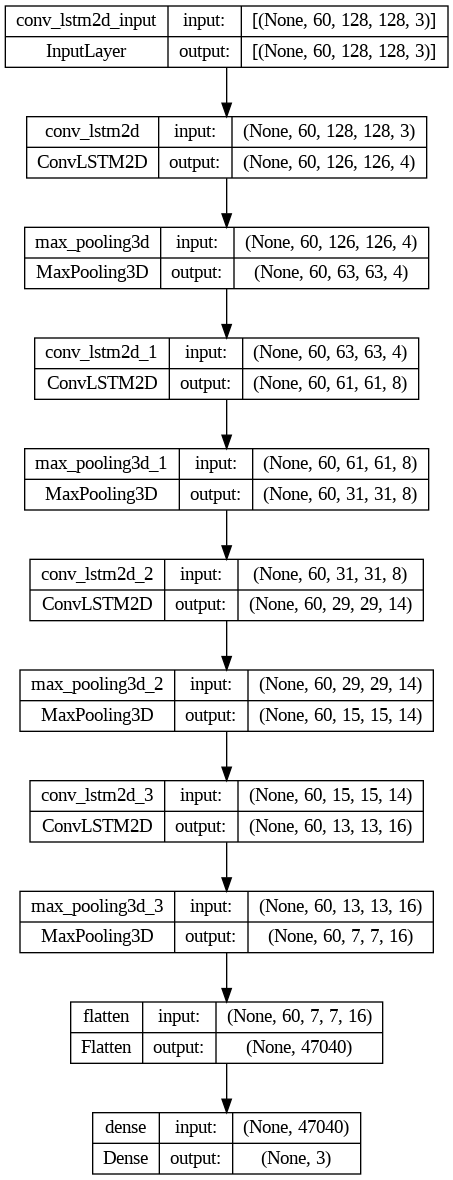

In [ ]:
plot_model(
    convlstm_model, to_file = 'convlstm_model_structure_plot.png',
    show_shapes = True, show_layer_names = True
)

In [ ]:
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', patience = 10,
    mode = 'min', restore_best_weights = True
)

convlstm_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ["accuracy"]
)

convlstm_model_training_history = convlstm_model.fit(
    x = features_train, y = labels_train, epochs = 20,
    batch_size = 4,shuffle = True, validation_split = 0.3
)

Epoch 1/20
8/8 [==============================] - 240s 29s/step - loss: 1.1388 - accuracy: 0.2903 - val_loss: 0.9673 - val_accuracy: 0.6429
Epoch 2/20
8/8 [==============================] - 221s 28s/step - loss: 0.9584 - accuracy: 0.5484 - val_loss: 0.8375 - val_accuracy: 0.6429
Epoch 3/20
8/8 [==============================] - 218s 28s/step - loss: 0.8318 - accuracy: 0.5806 - val_loss: 0.7357 - val_accuracy: 0.6429
Epoch 4/20
8/8 [==============================] - 219s 28s/step - loss: 0.9561 - accuracy: 0.4839 - val_loss: 0.9748 - val_accuracy: 0.5000
Epoch 5/20
8/8 [==============================] - 218s 28s/step - loss: 0.7882 - accuracy: 0.6129 - val_loss: 0.8942 - val_accuracy: 0.5714
Epoch 6/20
8/8 [==============================] - 219s 28s/step - loss: 0.8087 - accuracy: 0.6129 - val_loss: 0.8475 - val_accuracy: 0.6429
Epoch 7/20
8/8 [==============================] - 220s 28s/step - loss: 0.5647 - accuracy: 0.7419 - val_loss: 0.9723 - val_accuracy: 0.5714
Epoch 8/20
8/8 [====

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

1/1 [==============================] - 27s 27s/step - loss: 1.6426 - accuracy: 0.7333


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

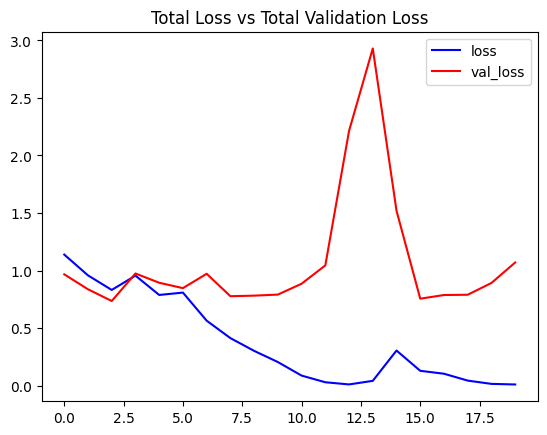

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

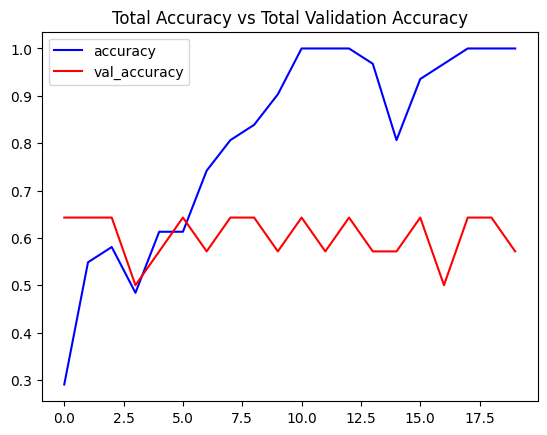

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)